# Example notebook for using the Multitask Neural Decoding code

This is an example notebook to explain the framework to train and evaluate a model using the multitask neural decoding codebase. After the relevant packages are installed, the entire notebook is self-contained and should run entirely in the Jupyter Notebook!

The goal of the project is to develop a more interpretable and better performing method of performing neural decoding across different tasks. The model is trained to perform clustering of the data into separate modes and then use the learned clustering to compute a weighted average over the different decoders in the model. The learned clustering information can be extracted for downstream analysis, which is explained in the "Evaluate trained model" section.

The code loads an example dataset of input data and output data, trains a model to decode the output from input, and evaluates the trained model (more details later in the notebook).

Feel free to reach out to Andrew at andrewshen2025@u.northwestern.edu if you have any questions!

### Import packages

See the provided "requirements.txt" file for specific versions of the installed packages.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.utilities import disable_possible_user_warnings
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score

### Define toy dataset

In [2]:
class Dataset_Toy(pl.LightningDataModule):
    
    def __init__(self, num_samples, num_neurons, num_muscles, num_modes, batch_size, dataset_type):
        super().__init__()
        self.num_samples = num_samples
        self.num_neurons = num_neurons
        self.num_muscles = num_muscles
        self.num_modes = num_modes
        self.batch_size = batch_size
        self.train_dataset = None
        self.val_dataset = None
        self.dataset_type = dataset_type
        self.decoder_mode1 = torch.randn(self.num_neurons, self.num_muscles)
        self.decoder_mode2 = torch.randn(self.num_neurons, self.num_muscles)

        # Generate toy features and labels
        self.train_dataset = self.generate_toy_dataset(self.num_samples)
        self.val_dataset = self.generate_toy_dataset(self.num_samples*0.2)


    def generate_behavioral(self, num_samples, m1_val, mode):
        """
        Helper function to generate data with behavioral labels for testing ClusterModel sub-model
        
        Input: (int) num_samples: number of samples
            (float) m1_val: value of the features in this mode
            (str) mode: which mode to generate
        Output: ([num_samples, num_neurons] tensor) features: output features
                ([num_samples] tensor) labels: output behavioral labels 
        """
        if mode == "mode1":
            labels = F.one_hot(torch.zeros(num_samples, dtype=int), self.num_modes)
        elif mode == "mode2":
            labels = F.one_hot(torch.ones(num_samples, dtype=int), self.num_modes)

        features = torch.full((num_samples, self.num_neurons), m1_val) + torch.randn(num_samples, self.num_neurons)
            
        return features, labels
    
    
    def generate_emg(self, num_samples, m1_val, decoder):
        """
        Helper function to generate data with EMG labels for testing the full CombinedModel
        
        Input: (int) num_samples: number of samples
            (float) m1_val: value of the features in this mode
        Output: ([num_samples, num_neurons] tensor) features: output features
                ([num_samples, num_muscles] tensor) labels: output EMG labels 
        """

        features = torch.full((num_samples, self.num_neurons), m1_val) + torch.randn(num_samples, self.num_neurons)
        labels = torch.matmul(features, decoder)

        return features, labels


    def generate_toy_dataset(self, num_samples):
        """
        Generates the final toy dataset
        Input: (int) num_samples: number of samples
        Output: ((feature, label) tuple) dataset: output dataset
        """
        
        # Dataset parameters
        num_samples_total = num_samples
        num_samples = int(num_samples_total/2)
        m1_val_mode1 = 10.0
        m1_val_mode2 = 0.0

        # Generate toy dataset with behavioral labels to test out ClusterModel
        if self.dataset_type == "behavioral":
            features_mode1, labels_mode1 = self.generate_behavioral(num_samples, m1_val_mode1, "mode1")
            features_mode2, labels_mode2 = self.generate_behavioral(num_samples, m1_val_mode2, "mode2")
        
        # Generate toy dataset with EMG labels to test out full CombinedModel
        elif self.dataset_type == "emg":
            features_mode1, labels_mode1 = self.generate_emg(num_samples, m1_val_mode1, self.decoder_mode1)
            features_mode2, labels_mode2 = self.generate_emg(num_samples, m1_val_mode2, self.decoder_mode2)
        
        # Format datasets in pairs of (feature, label)
        dataset_mode1 = [(features_mode1[i], labels_mode1[i]) for i in range(len(features_mode1))]
        dataset_mode2 = [(features_mode2[i], labels_mode2[i]) for i in range(len(features_mode2))]
        dataset = dataset_mode1 + dataset_mode2

        return dataset
    
    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        return self.train_dataset[index]

    def collate_fn(self, batch):
        final_batch = {}
        X = []
        Y = []
        for sample in batch:
            X.append(sample[0])
            Y.append(sample[1])
        final_batch["m1"] = torch.stack(X)
        final_batch["emg"] = torch.stack(Y).float()
        return final_batch

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)


### Define model

In [3]:
# Clustering model
class ClusterModel(nn.Module):
    """
    input_dim: N
    num_modes: d
    """

    def __init__(self, input_dim, num_modes):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(input_dim, 1) for i in range(num_modes)])
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        x_d = []
        for linear in self.linears:
            x_d.append(linear(x))
        x = torch.stack(x_d, 2)
        x = self.softmax(x) 
        return x
    
    
# Decoding model
class DecoderModel(nn.Module):
    """
    input_dim: N
    output_dim: M
    num_modes: d
    """
    
    def __init__(self, input_dim, output_dim, num_modes):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(input_dim, output_dim) for i in range(num_modes)])
    
    def forward(self, x):
        x_d = []
        for linear in self.linears:
            x_d.append(linear(x))
        x = torch.stack(x_d, 2)
        return x


class CombinedModel(nn.Module):
    """
    self.cm stores an instance of the cluster model
    self.dm stores an instancee of the decoding model
    """

    def __init__(self, input_dim, output_dim, num_modes, ev):
        super(CombinedModel, self).__init__()
        self.cm = ClusterModel(input_dim, num_modes)
        self.dm = DecoderModel(input_dim, output_dim, num_modes)
        self.ev = ev

    def forward(self, x):
        x1 = self.cm(x)
        x2 = self.dm(x)
        output = torch.sum(x1 * x2, dim=-1)

        # Return softmax outputs if mode is "eval"
        if self.ev == True:
            return x1
        return output

### Define training module

In [4]:
class TrainingModule(LightningModule):

    def __init__(self, model, lr, type):
        super().__init__()
        self.model = model
        self.lr = lr
        self.dataset_type = type
        self.training_step_labels = []
        self.training_step_preds = []
        self.val_step_labels = []
        self.val_step_preds = []

    def forward(self, x):
        return self.model.forward(x)
    
    def training_step(self, batch):
        features = batch["m1"]
        labels = batch["emg"]
        labels_hat = self.model(features).squeeze()
        train_loss = F.mse_loss(labels_hat, labels)
        self.log("train_loss", train_loss, on_step=True)
        self.training_step_labels += labels.tolist()
        self.training_step_preds += labels_hat.tolist()
        return train_loss

    def validation_step(self, batch):
        features = batch["m1"]
        labels = batch["emg"]
        labels_hat = self.model(features).squeeze()
        val_loss = F.mse_loss(labels_hat, labels)
        self.log("val_loss", val_loss, on_epoch=True)
        self.val_step_labels += labels.tolist()
        self.val_step_preds += labels_hat.tolist()
        return val_loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer
    
class Callback(pl.Callback):
    
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        self.epoch_number = 0
        self.train_losses = []
        self.train_r2s = []


    def on_train_epoch_end(self, trainer, pl_module):
        
        # Calculate loss over the epoch
        labels = torch.Tensor(pl_module.training_step_labels)
        labels_hat = torch.Tensor(pl_module.training_step_preds)
        train_loss_epoch = F.mse_loss(labels_hat, labels)
        self.train_losses.append(train_loss_epoch.item())

        # Calculate R^2 metric
        train_r2 = r2_score(labels, labels_hat)
        pl_module.log("train_r2", train_r2)
        self.train_r2s.append(train_r2)
        # print(train_r2)

        # Reset stored labels and preds for current epoch
        pl_module.training_step_labels = []
        pl_module.training_step_preds = []
        self.epoch_number += 1


### Load dataset and train the model

The trained model is saved in the path: "checkpoints/checkpoints.ckpt"

In [5]:
# Load in dataset
T = 500 # number of samples TODO: Change back to 5000
N = 10 # number of neurons
M = 3 # number of muscles
d = 3 # number of modes
b = 8 # batch size
type = "emg"
epochs = 100 # numbr of epochs
lr = 0.0001 # learning rate
save_path = "checkpoints"
dataset = Dataset_Toy(num_samples=T,
                             num_neurons=N,
                             num_muscles=M,
                             num_modes=d,
                             batch_size=b,
                             dataset_type=type)

# Define model
model = CombinedModel(input_dim=N,
                        output_dim=M,
                        num_modes=d, 
                        ev=False)
model = TrainingModule(model=model,
                        lr=lr,
                        type=type)

# Define model checkpoints
filename = "checkpoints/checkpoints.ckpt"
if os.path.exists(filename):
    os.remove(filename)
save_callback = ModelCheckpoint(dirpath = save_path, filename="checkpoints")

# Define trainer
trainer = Trainer(max_epochs=epochs, callbacks=[Callback(dataset), save_callback], enable_progress_bar=False, logger=False)

# Fit the model
disable_possible_user_warnings()
trainer.fit(model, train_dataloaders=dataset.train_dataloader(), val_dataloaders=dataset.val_dataloader())


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params
----------------------------------------
0 | model | CombinedModel | 132   
----------------------------------------
132       Trainable params
0         Non-trainable params
132       Total params
0.001     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


### Display model logs

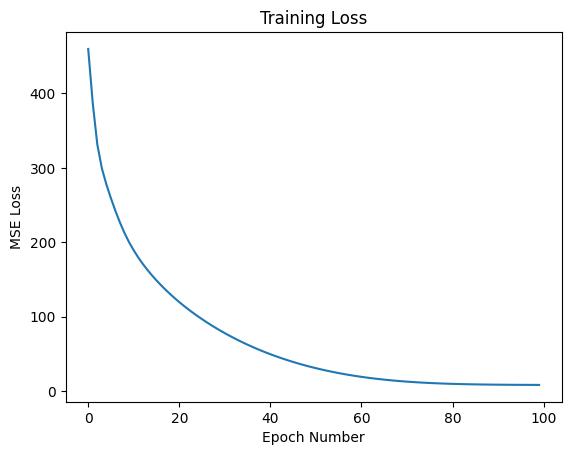

In [6]:
# Plot training losses
train_losses = trainer.callbacks[0].train_losses
plt.title("Training Loss")
plt.xlabel("Epoch Number")
plt.ylabel("MSE Loss")
plt.plot(range(len(train_losses)), train_losses)
plt.show()


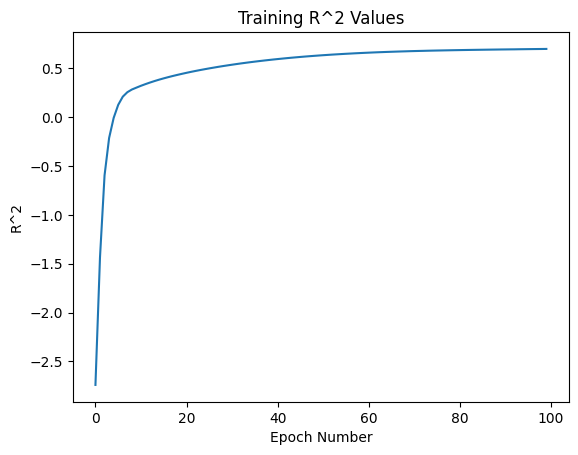

Final Train R^2 Value: 0.700522621094766


In [7]:
# Plot training R^2 values
train_r2s = trainer.callbacks[0].train_r2s
plt.title("Training R^2 Values")
plt.xlabel("Epoch Number")
plt.ylabel("R^2")
plt.plot(range(len(train_r2s)), train_r2s)
plt.show()
print("Final Train R^2 Value: %s" % train_r2s[-1])

### Evaluate trained model

To view the learned cluster probabilities for each mode, the input training data is fed through the model again to generate the learned clusters and stored in the variable "cluster_probs".

Relevant Variables
1. cm_weights: model weights for the Cluster model
2. dm_weighs: model weights for the Decoder model
3. cluster_probs: learned cluster probabilities for each mode, has shape of (num_samples, num_modes)
4. train_emgs: ground truth values for EMG data, has shape of (num_samples, num_muscles)
5. final_preds: final predictions from the model, has shape of (num_samples, num_muscles)

*Sanity check: "final_preds" values should be similar to "train_emgs" as the EMG data is the output data to be decoded



In [8]:
# Access train dataset
train = dataset.train_dataset

# Load trained model
model_path = filename
model = CombinedModel(input_dim=N,
                      output_dim=M,
                      num_modes=d,
                      ev=True)
checkpoint = torch.load(model_path)
state_dict = checkpoint["state_dict"]
model = TrainingModule(model=model,
                       lr=lr,
                       type=type)
model.load_state_dict(state_dict)

# Extract learned cluster model weights
cm_weights = model.model.cm.parameters()

# Extract learned decoder model weights
dm_weights = model.model.dm.parameters()

# Calculate learned cluster labels
"""
Output learned clusters will be of shape (num_samples, num_modes)
Ex: [0.0000, 0.0017, 0.9983] for num_modes=3 means the model learned that using 99.83% of mode 3 resulted in best performance
"""
cluster_probs = []
for sample in train:
    x = sample[0].unsqueeze(0)
    curr_probs = model.forward(x)
    cluster_probs.append(curr_probs.squeeze())
cluster_probs = torch.stack(cluster_probs).detach()
torch.set_printoptions(sci_mode=False)
print("Learned cluster probabilities:\n%s" % cluster_probs)

# Calculate final predictions
"""
Output predictions will be of shape (num_samples, num_muscles)
"""
model.model.ev = False
final_preds = []
for sample in train:
    x = sample[0].unsqueeze(0)
    pred = model.forward(x)
    final_preds.append(pred.squeeze())
final_preds = torch.stack(final_preds).detach()
print("\nFinal predictions:\n%s" % final_preds)

# Compare final predictions to output EMG data
train_emgs = torch.stack([sample[1] for sample in train])
print("\nEMG values:\n%s" % train_emgs)

Learned cluster probabilities:
tensor([[    0.9998,     0.0001,     0.0001],
        [    0.9998,     0.0001,     0.0001],
        [    0.9996,     0.0002,     0.0003],
        ...,
        [    0.4982,     0.2105,     0.2913],
        [    0.1563,     0.6995,     0.1442],
        [    0.2049,     0.2402,     0.5549]])

Final predictions:
tensor([[44.8892,  7.1356, -7.1067],
        [46.8344,  6.7837, -6.9844],
        [47.1001,  6.2051, -6.4884],
        ...,
        [ 0.5376, -0.3819,  0.3460],
        [ 0.2337, -0.4407, -0.2335],
        [-0.4810,  1.2145, -0.7715]])

EMG values:
tensor([[ 46.2310,   8.3556, -10.9232],
        [ 46.9945,   8.0284,  -9.3497],
        [ 41.2429,   7.3635,  -5.8214],
        ...,
        [ -1.1178,  -5.2083,   1.2916],
        [ -3.1423,  -0.5029,   0.5707],
        [ -1.8695,  10.4142,  -1.9620]])
